
Attaching package: 'dplyr'

The following objects are masked from 'package:data.table':

    between, first, last

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: mice
Loading required package: lattice

Attaching package: 'mice'

The following object is masked from 'package:tidyr':

    complete

The following objects are masked from 'package:base':

    cbind, rbind

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4

Attaching package: 'dlookr'

The following object is masked from

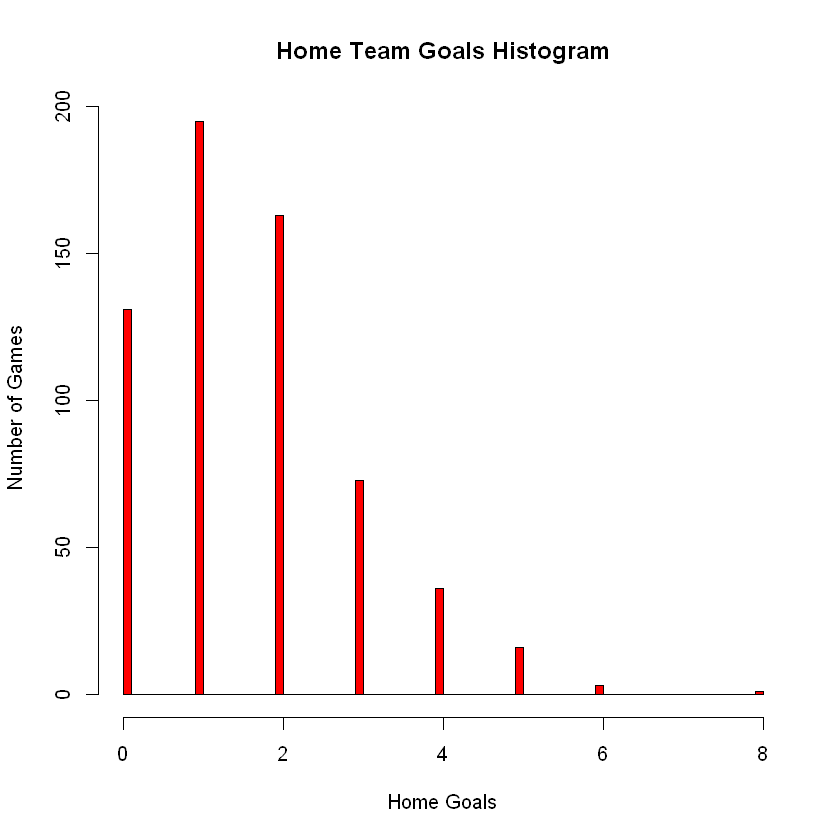

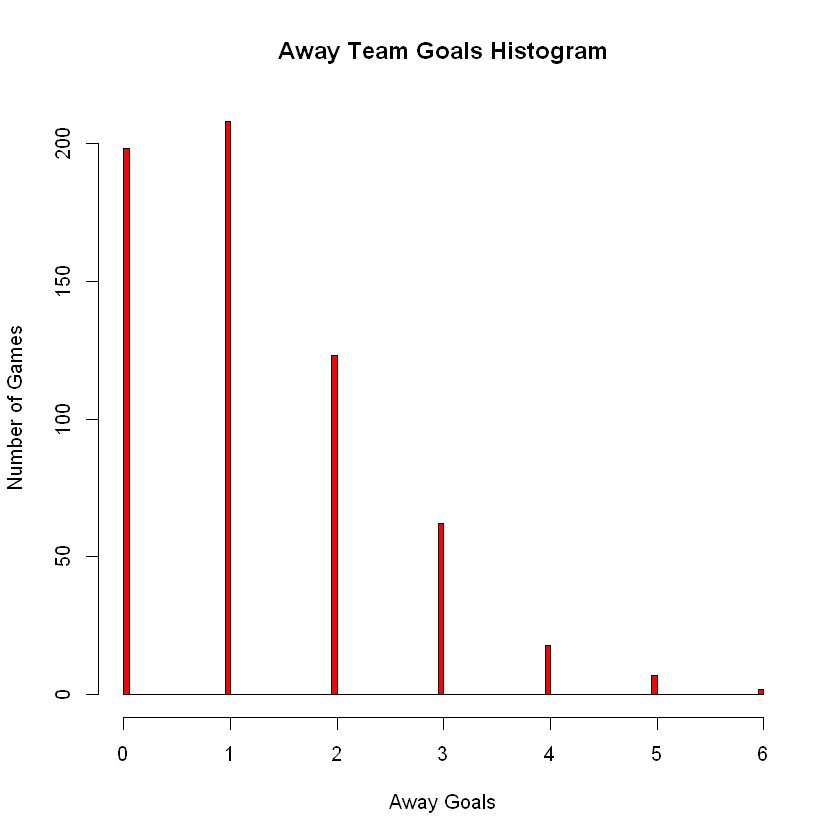

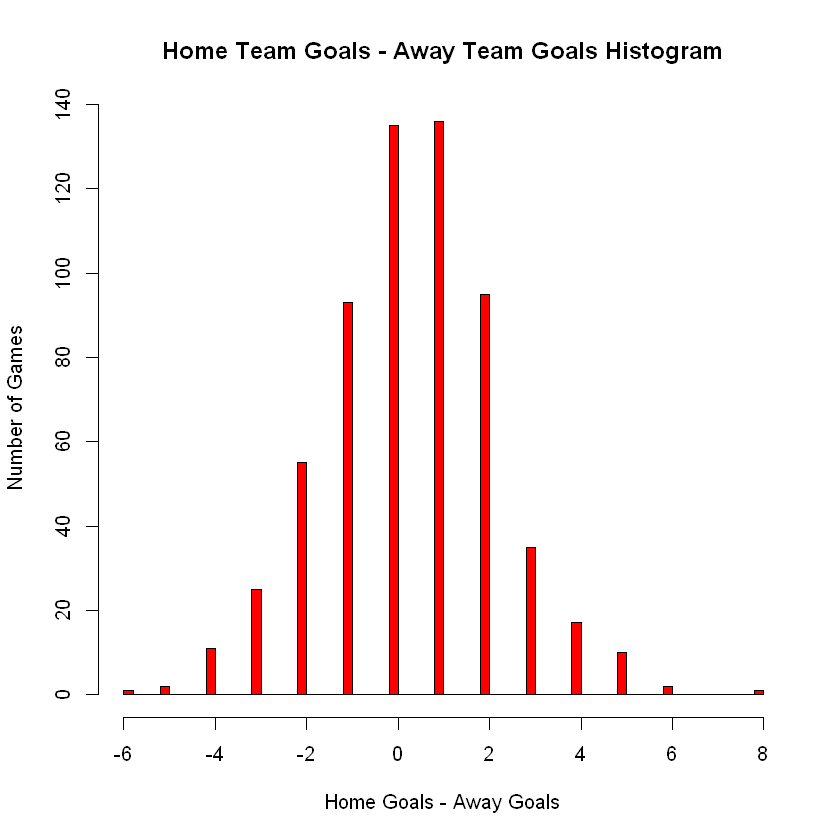

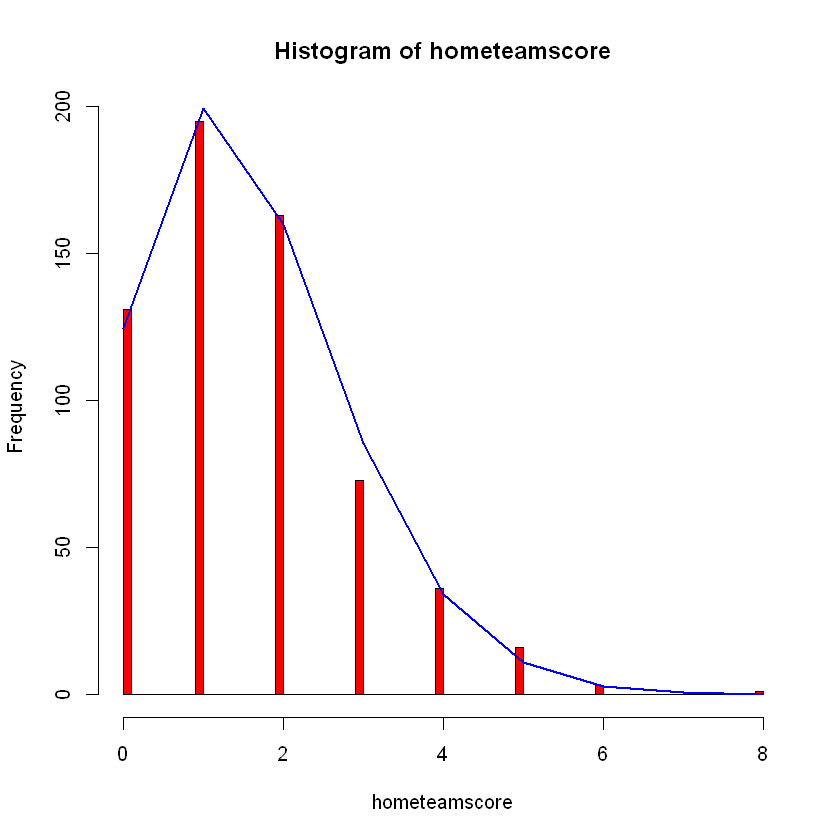

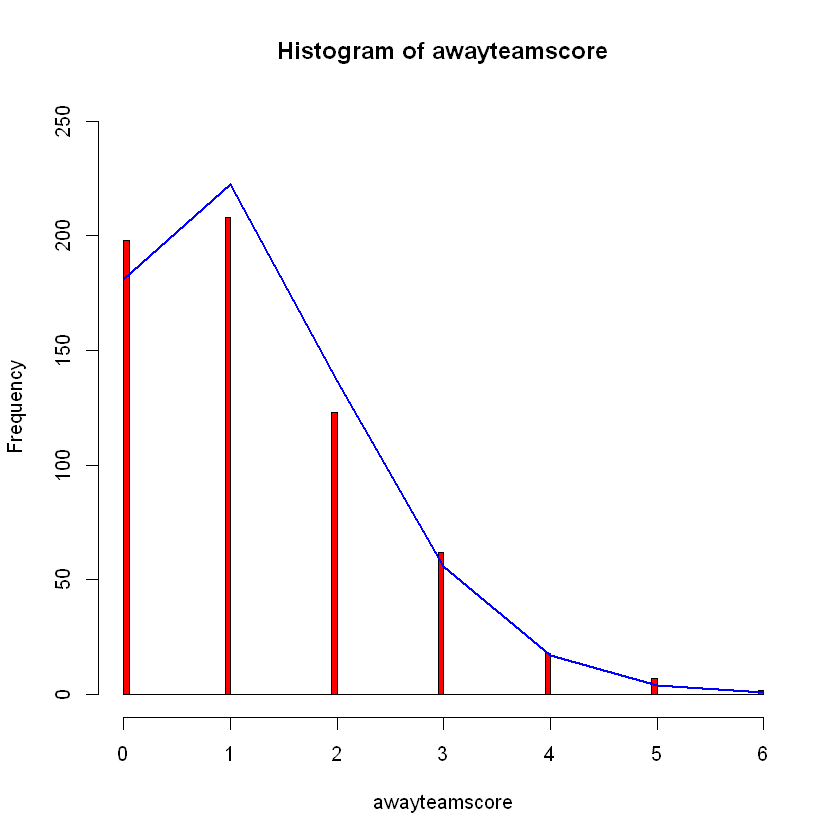

Warning message in eval(.massagei(isub), x, ienv):
"NAs introduced by coercion"

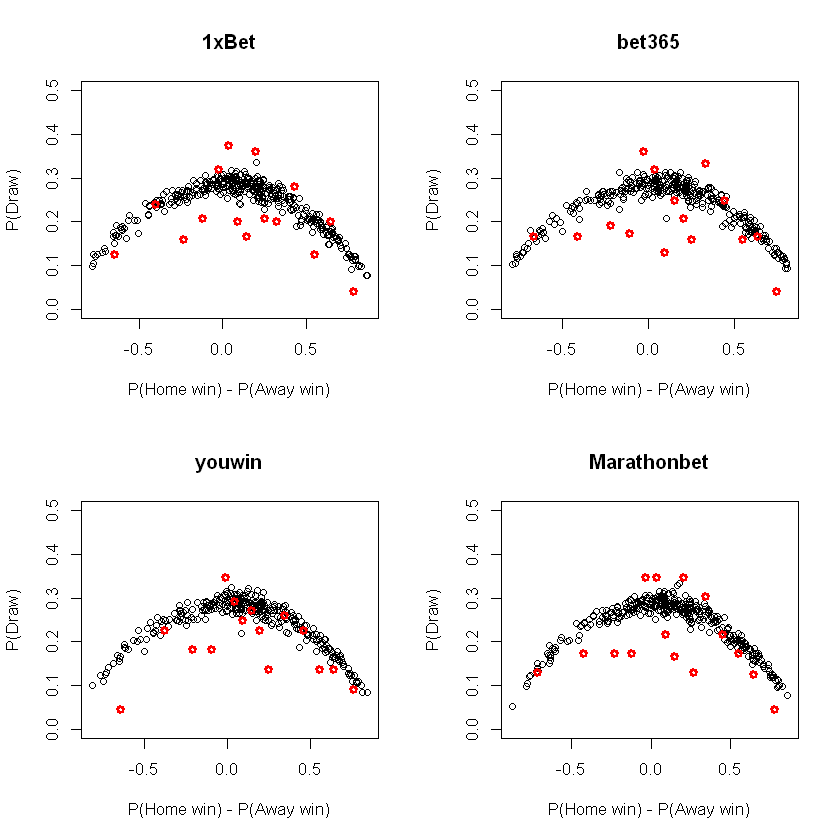

faulmatches lastminmatches    bothmatches       fauldata    lastmindata 
             3             34              1              3             45 
      bothdata 
             1

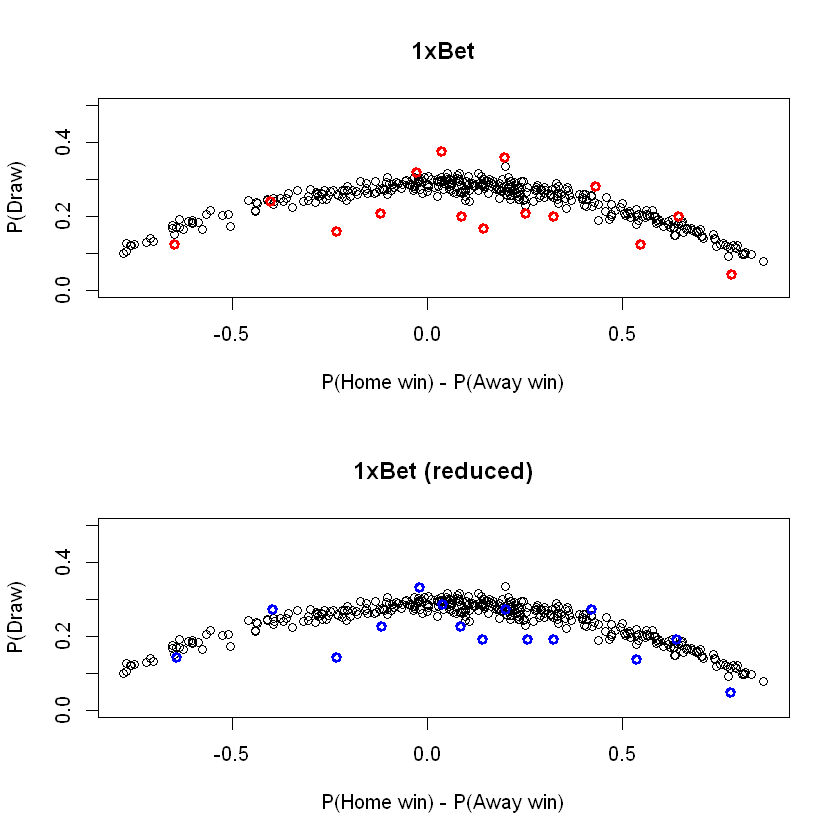

faulmatches lastminmatches    bothmatches       fauldata    lastmindata 
             3             34              1              3             45 
      bothdata 
             1

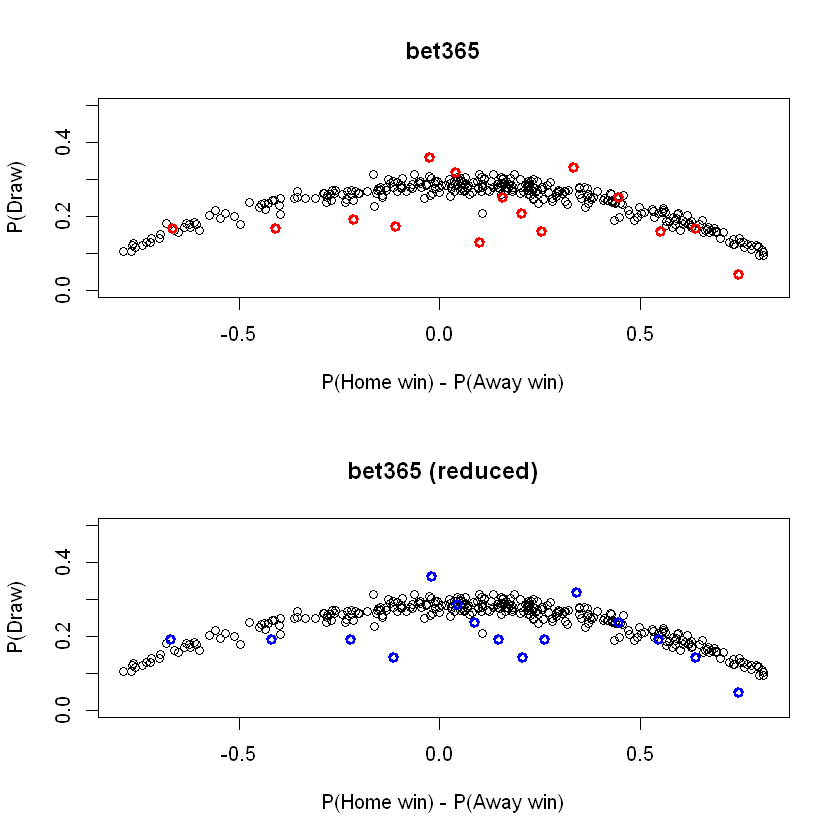

faulmatches lastminmatches    bothmatches       fauldata    lastmindata 
             3             34              1              3             41 
      bothdata 
             1

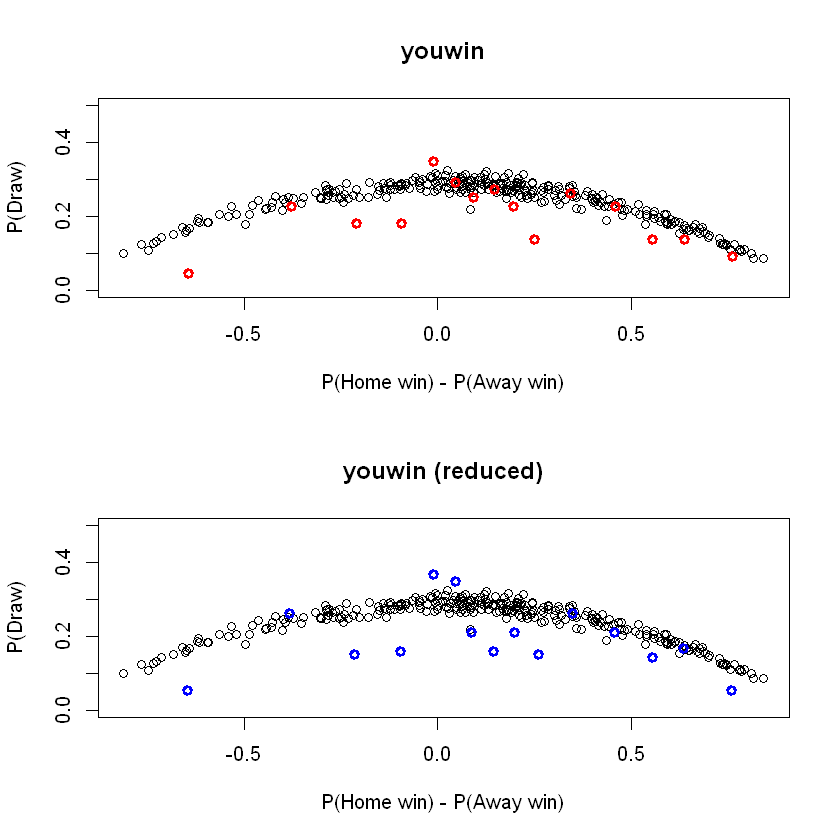

faulmatches lastminmatches    bothmatches       fauldata    lastmindata 
             3             34              1              3             41 
      bothdata 
             1

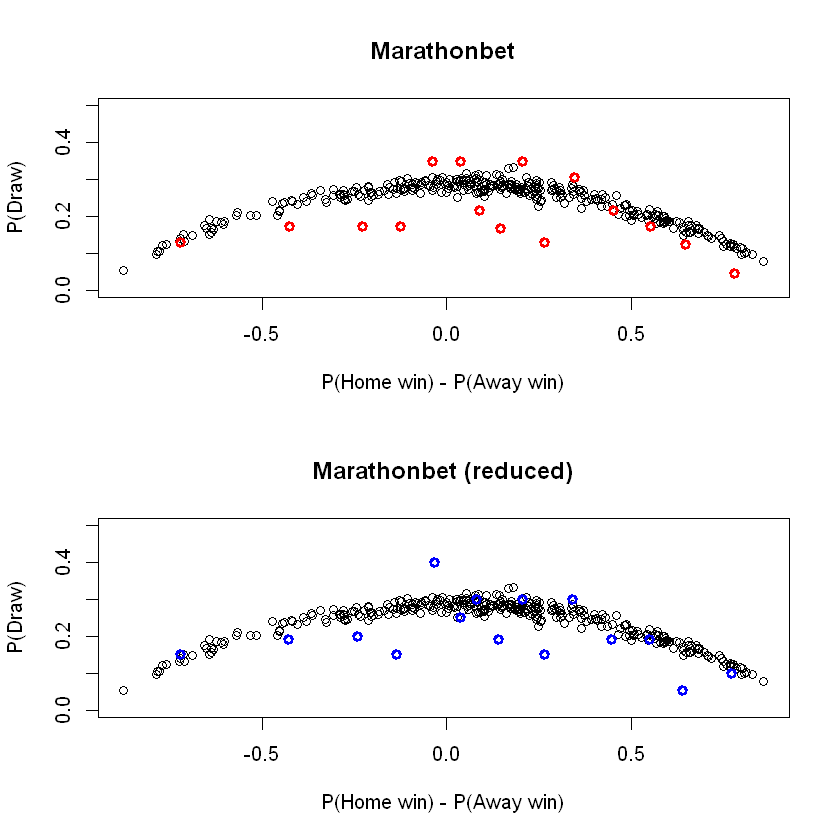

In [1]:
setwd("C:/Users/Orkun/Desktop/IE 582 - HW 1")

library(data.table)
library(dplyr)
library(tidyr)
library(dlookr)

#Import the necessary data 
goals<-fread("goals.csv",header=TRUE)
matches<-fread("matches.csv",header=TRUE)
bets<-fread("bets.csv")  
bookings<-fread("booking.csv")  

#Filter out the unplayed matches and use only English Premier League games
EPL<- matches[league_id == "148" &  match_status != "NA" ]
  

###Task 1

#Create vectors for  Home Score(goals), Away Score(goals) and Home Score(goals)– Away Score(goals)
hometeamscore<-EPL$match_hometeam_score
awayteamscore<-EPL$match_awayteam_score
difference<-hometeamscore - awayteamscore

#Create histograms for each one
#Task 1.1a
hh<-hist(hometeamscore,breaks = 100,col = "red", xlab = "Home Goals", ylab = "Number of Games", main = "Home Team Goals Histogram" )
#Task 1.1b
ha<-hist(awayteamscore, breaks = 100, col = "red", xlab = "Away Goals", ylab = "Number of Games", main = "Away Team Goals Histogram")
#Task 1.1c
hd<-hist(difference, breaks = 100, col = "red", xlab = "Home Goals - Away Goals", ylab = "Number of Games", main = "Home Team Goals - Away Team Goals Histogram")

#Task 1.2
#To add the poisson find the means first
mhm<-mean(hometeamscore)
maw<-mean(awayteamscore)


#Add poisson dist values using the mean of home win 
plot(hh,col = "red")
xfit<-seq(min(hometeamscore),max(hometeamscore),length=9)
yfit<-dpois(xfit,mhm)
yfit <- yfit*length(hometeamscore)
lines(xfit, yfit, col="blue", lwd=2)

#Add poisson dist values using the mean of away win
plot(ha,col = "red" ,ylim = c(0,250))
xfit<-seq(min(awayteamscore),max(awayteamscore),length=7)
yfit<-dpois(xfit,maw)
yfit <- yfit*length(awayteamscore)
lines(xfit, yfit, col="blue", lwd=2)

#Both graphs seems to consistent with the poisson dist.



### Task 2

#To obtain the match results create a data frame using match_id, home score, away score and an empty Result column
EPL_results<- data.frame("match_id"=EPL$match_id,"Home Score"=EPL$match_hometeam_score,"Away Score"=EPL$match_awayteam_score,"Result"=0)

#Since we are interested in games ended as draw put 1 to results column for draws 0 otherwise
for (i in 1:length(EPL_results$match_id)) {
if(EPL_results$Home.Score[i] > EPL_results$Away.Score[i]) {EPL_results$Result[i]=0}
if(EPL_results$Home.Score[i] < EPL_results$Away.Score[i]) {EPL_results$Result[i]=0}
if(EPL_results$Home.Score[i] == EPL_results$Away.Score[i]) {EPL_results$Result[i]=1}
}
#We will use this table afterwards to calculate implied probabilities

#Continue with calculating probabilities from odds
#Reduce to only single bets as Task Requires
singlebets<-bets[variable=="odd_1" | variable=="odd_2" | variable=="odd_x"  ]
#Reduce to only EPL matches
EPL_singlebets<-singlebets[is.element(match_id,EPL_results$match_id)]

plot_Q2<- function(bookmaker)
{
#Function to plot the P(Home)-P(Away) vs P(Draw) with calculated probabilities  


#Collect Odd(Home),Odd(Away) and Odd(Draw) in the same row for same bet 
b1<-EPL_singlebets[odd_bookmakers == bookmaker]
b2<-b1[order(match_id)]
b3<-spread(b2,variable,value)

#Task 2.1
#Convert Odd(Home),Odd(Away) and Odd(Draw) to corrresponding probabilities
b3$odd_1=1/b3$odd_1 
b3$odd_x=1/b3$odd_x
b3$odd_2=1/b3$odd_2

#Task 2.2
#Normalize the probabilities
b3<-cbind(b3, SUM = b3$odd_1+b3$odd_2+b3$odd_x)
b3<-cbind(b3, np_1 = b3$odd_1/b3$SUM)
b3<-cbind(b3, np_2 = b3$odd_2/b3$SUM)
b3<-cbind(b3, np_x = b3$odd_x/b3$SUM)

#Task 2.3
#Find the difference of P(Home) - P(Away) and add as a column
b3<-cbind(b3, DIF = b3$np_1-b3$np_2)

#Plot the Probabilities
plot(b3$DIF, b3$np_x  ,xlab = "P(Home win) - P(Away win)" ,ylab = "P(Draw)",main = bookmaker , ylim = c(0,0.5))

#To calculate number of draws in a bin add the results to the current table
b4<-data.frame(match_id=EPL_results$match_id, Result=EPL_results$Result)
b3<-merge.data.frame(b3,b4, by = "match_id")

#To create bins use binning function, 
#To examine equal number of matches each time chose "quantile"
bn<-binning(b3$DIF,type = "quantile",nbins = 15)

#To calculate the proportion of draws in a level simply take the average
#since result is 1 for draw and 0 for others
bins<-data.frame(limits=bn ,DIF = b3$DIF, RES=b3$Result, match_id = b3$match_id )
bins<-aggregate.data.frame(bins[3], by = list(bins$limits) , FUN = mean ,order =)

#to find the cutoff points of bins use quantile function
#calculate the mid points by taking average of pairs
a1<-quantile(b3$DIF, probs = seq(0,1,1/15))
a2<-0
for (i in 1:15) {
  a2[i]<-(a1[i]+a1[i+1])/2
}

#plot the calculated probability and midpoint of the bins
points(a2,bins$RES, col="red", lwd = 3)
}

#Task 2.4 continued:
par(mfrow=c(2,2))
plot_Q2("1xBet")
plot_Q2("bet365")
plot_Q2("youwin")
plot_Q2("Marathonbet")

#When we evaluate 4 graph, although in general implied probabilities of bins are close
#to odd probabilities, there are some bin probabilities larger than the odds. Especially near
#zero P(Home)-P(Away) values we observe one or two bins giving larger possibilities,
#which means one can bet draw and gain profit in the long run.



###Task 3

#Match is removed if the last goal is at 90th min or later
uzatma<-goals[time >= 90 ]

#Match is removed if there is a red card in the first 20 min
earlyfauls<-bookings[ as.numeric(time) <= 20 & card == "red card"]

#Adjust plot_Q2 function to apply the constraints above
plot_Q3<- function(bookmaker)
{
  #Function to plot the P(Home)-P(Away) vs P(Draw) with calculated probabilities  
  #Additionally some matches are discarded to eliminate irregularities  
  #Collect Odd(Home),Odd(Away) and Odd(Draw) in the same row for same bet 
  b1<-EPL_singlebets[odd_bookmakers == bookmaker]
  b2<-b1[order(match_id)]
  b3<-spread(b2,variable,value)
  
  #Convert Odd(Home),Odd(Away) and Odd(Draw) to corrresponding probabilities
  b3$odd_1=1/b3$odd_1 
  b3$odd_x=1/b3$odd_x
  b3$odd_2=1/b3$odd_2
  
  #Normalize the probabilities
  b3<-cbind(b3, SUM = b3$odd_1+b3$odd_2+b3$odd_x)
  b3<-cbind(b3, np_1 = b3$odd_1/b3$SUM)
  b3<-cbind(b3, np_2 = b3$odd_2/b3$SUM)
  b3<-cbind(b3, np_x = b3$odd_x/b3$SUM)
  
  #Find the difference of P(Home) - P(Away) and add as a column
  b3<-cbind(b3, DIF = b3$np_1-b3$np_2)
  
  #Plot the Probabilities
  plot(b3$DIF, b3$np_x  ,xlab = "P(Home win) - P(Away win)" ,ylab = "P(Draw)",main = paste(bookmaker,"(reduced)", sep = " ") , ylim = c(0,0.5))
  
  #Add the results to the current table
  b4<-data.frame(match_id=EPL_results$match_id, Result=EPL_results$Result)
  b3<-merge.data.frame(b3,b4, by = "match_id")
  
  #Filter out the last min goals and count the number 
  b5<-filter(b3, !is.element(b3$match_id,uzatma$match_id))
  data_long=length(b3$match_id)-length(b5$match_id)
  num_long=length(b3$match_id[!duplicated(b3$match_id)])-length(b5$match_id[!duplicated(b5$match_id)])
  
  #Filter out the early fauls and count the number
  b6<-filter(b3, !is.element(b3$match_id,earlyfauls$match_id))
  data_earlyfaul=length(b3$match_id)-length(b6$match_id)
  num_earlyfaul=length(b3$match_id[!duplicated(b3$match_id)])-length(b6$match_id[!duplicated(b6$match_id)])
  
  #Filter both and count the number, use b7 for the rest
  b7<-filter(b3, !is.element(b3$match_id,earlyfauls$match_id) & !is.element(b3$match_id,uzatma$match_id) )
  data_both=length(b3$match_id)-length(b7$match_id)
  num_both=length(b3$match_id[!duplicated(b3$match_id)])-length(b7$match_id[!duplicated(b7$match_id)])
  
  #To create bins use binning function, 
  #To examine equal number of matches each time chose "quantile"
  bn<-binning(b7$DIF,type = "quantile",nbins = 15)
  
  #To calculate the proportion of draws in a level simply take the average
  #since result is 1 for draw and 0 for others
  bins<-data.frame(limits=bn ,DIF = b7$DIF, RES=b7$Result, match_id = b7$match_id )
  bins<-aggregate.data.frame(bins[3], by = list(bins$limits) , FUN = mean ,order =)
  
  #to find the cutoff points of bins use quantile function
  #calculate the mid points by taking average of pairs
  a1<-quantile(b7$DIF, probs = seq(0,1,1/15))
  a2<-0
  for (i in 1:15) {
    a2[i]<-(a1[i]+a1[i+1])/2
  }
  
  #plot the calculated probability and midpoint of the bins
  points(a2,bins$RES, col="blue", lwd = 3)

  #return the number of early fauls and lastmin games and their intersection if any
  #name data implies how many data point is deleted whereas name matches is the number of matches discarded
  c(faulmatches=num_earlyfaul,lastminmatches=num_long,bothmatches= num_earlyfaul + num_long - num_both,fauldata=data_earlyfaul,lastmindata=data_long,bothdata= data_earlyfaul + data_long - data_both)
  }


par(mfrow=c(2,1))
plot_Q2("1xBet")
plot_Q3("1xBet")

plot_Q2("bet365")
plot_Q3("bet365")

plot_Q2("youwin")
plot_Q3("youwin")

plot_Q2("Marathonbet")
plot_Q3("Marathonbet")

#In general we can say that bin probabilities are closer to the odd probabilities 
#for the reduced case, which means intution to filter out such marginal cases seems to works 
#since we expect that betmakers to give adjusted odds so that they can win in the long run.  